In [1]:
import numpy as np
import gc
import os
import time
import sklearn.preprocessing

from helpers import *

global result_dir

class ANNExperiment:
    def __init__(self, dataset_name, k, metric, result_dir):
        self.dataset_name = dataset_name
        self.k = k
        self.metric = metric
        self.result_dir = result_dir
        self.results = {}

        self.train, self.test, self.dim = load_and_transform_dataset(self.dataset_name)
        if self.metric == 'cosine':
            self.train = sklearn.preprocessing.normalize(self.train, axis=1, norm="l2")
            self.test = sklearn.preprocessing.normalize(self.test, axis=1, norm="l2")

        print("Dataset Loaded")
        print("="*21)
        self.filename = dataset_name.split('-')[0]
        
        # brute force ground truth
        print('Running Brute Force')
        start = time.time()
        brute = build_brute(self.train, self.dim, metric='l2')
        brute_build_time = time.time() - start
        print(f'Brute Build Time: {brute_build_time} seconds')

        start = time.time()
        self.brute_labels, self.brute_dist = run_brute(brute, self.test, self.k)
        brute_query_time = time.time() - start
        print(f'Brute Query Time: {brute_query_time} seconds')
        print("="*21)

        self.results['brute'] = {}
        self.results['brute']['build_time'] = brute_build_time
        self.results['brute']['query_time'] = brute_query_time

        brute_export_index(brute, f"brute_index_{self.filename}", self.result_dir)
        export_to_hdf5(self.brute_labels, f"brute_labels_{self.filename}", f"brute_labels_{self.filename}", self.result_dir)
        export_to_hdf5(self.brute_dist, f"brute_dist_{self.filename}", f"brute_dist_{self.filename}", self.result_dir)
        
    def run_experiment(self):

        # hnsw
        print('Running HNSW')
        
        start = time.time()
        hnsw = build_hnsw(self.train, self.dim, metric='l2')
        hnsw_build_time = time.time() - start
        print(f'HNSW Build Time: {hnsw_build_time} seconds')

        start = time.time()
        hnsw_labels, hnsw_dist = run_hnsw(hnsw, self.test, self.k)
        hnsw_query_time = time.time() - start
        print(f'HNSW Query Time: {hnsw_query_time} seconds')

        hnsw_recall = np.mean(recall(hnsw_labels, self.brute_labels))
        print(f'HNSW Recall: {hnsw_recall}')
        print("="*21)

        self.results['hnsw'] = {}
        self.results['hnsw']['recall'] = hnsw_recall
        self.results['hnsw']['build_time'] = hnsw_build_time
        self.results['hnsw']['query_time'] = hnsw_query_time

        hnsw_export_index(hnsw, f"hnsw_index_{self.filename}", self.result_dir)
        export_to_hdf5(hnsw_labels, f"hnsw_labels_{self.filename}", f"hnsw_labels_{self.filename}", self.result_dir)
        export_to_hdf5(hnsw_dist, f"hnsw_dist_{self.filename}", f"hnsw_dist_{self.filename}", self.result_dir)

        # flann
        print('Running FLANN')

        start = time.time()
        flann = build_flann(self.train, metric='l2')
        flann_build_time = time.time() - start
        print(f'FLANN Build Time: {flann_build_time} seconds')

        start = time.time()
        flann_labels, flann_dist = run_flann(flann, self.test, self.k, metric='l2')
        flann_query_time = time.time() - start
        print(f'FLANN Query Time: {flann_query_time} seconds')

        flann_recall = np.mean(recall(flann_labels, self.brute_labels))
        print(f'FLANN Recall: {flann_recall}')
        print("="*21)

        self.results['flann'] = {}
        self.results['flann']['recall'] = flann_recall
        self.results['flann']['build_time'] = flann_build_time
        self.results['flann']['query_time'] = flann_query_time

        flann_export_index(flann, f"flann_index_{self.filename}", self.result_dir)
        export_to_hdf5(flann_labels, f"flann_labels_{self.filename}", f"flann_labels_{self.filename}", self.result_dir)
        export_to_hdf5(flann_dist, f"flann_dist_{self.filename}", f"flann_dist_{self.filename}", self.result_dir)

        # annoy
        print('Running Annoy')

        start = time.time()
        annoy = build_annoy(self.train, self.dim, 500, metric='l2', n_jobs=-1)
        annoy_build_time = time.time() - start
        print(f'Annoy Build Time: {annoy_build_time} seconds')

        start = time.time()
        annoy_res = run_annoy(annoy, self.test, self.k)
        annoy_query_time = time.time() - start
        print(f'Annoy Query Time: {annoy_query_time} seconds')

        annoy_labels, annoy_dist = transform_annoy_result(annoy_res)
        del annoy_res
        gc.collect()

        annoy_recall = np.mean(recall(annoy_labels, self.brute_labels))
        print(f'Annoy Recall: {annoy_recall}')
        print("="*21)

        self.results['annoy'] = {}
        self.results['annoy']['recall'] = annoy_recall
        self.results['annoy']['build_time'] = annoy_build_time
        self.results['annoy']['query_time'] = annoy_query_time

        annoy_export_index(annoy, f"annoy_index_{self.filename}", self.result_dir)
        export_to_hdf5(annoy_labels, f"annoy_labels_{self.filename}", f"annoy_labels_{self.filename}", self.result_dir)
        export_to_hdf5(annoy_dist, f"annoy_dist_{self.filename}", f"annoy_dist_{self.filename}", self.result_dir)

In [3]:
all_data_result_dict = {}

In [4]:
dataset_name = 'sift-128-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already
result_dir = './result/sift'
os.makedirs(result_dir, exist_ok=True)

exp = ANNExperiment(dataset_name, k, metric, result_dir)
exp.run_experiment()

# get accuracy results
all_data_result_dict['sift'] = exp.results
exp.results

Got a train set of size (1000000 * 128)
Got 10000 queries
Dataset Loaded
Running Brute Force
Brute Build Time: 0.5026280879974365 seconds
Brute Query Time: 279.39087867736816 seconds
Running HNSW
HNSW Build Time: 123.6417624950409 seconds
HNSW Query Time: 0.14356136322021484 seconds
HNSW Recall: 0.70828
Running FLANN
FLANN Build Time: 638.7001960277557 seconds
FLANN Query Time: 13.044065952301025 seconds
FLANN Recall: 0.82904
Running Annoy
Annoy Build Time: 273.279093503952 seconds
Annoy Query Time: 22.34026789665222 seconds
Annoy Recall: 0.9267200000000001


{'brute': {'build_time': 0.5026280879974365, 'query_time': 279.39087867736816},
 'hnsw': {'recall': 0.70828,
  'build_time': 123.6417624950409,
  'query_time': 0.14356136322021484},
 'flann': {'recall': 0.82904,
  'build_time': 638.7001960277557,
  'query_time': 13.044065952301025},
 'annoy': {'recall': 0.9267200000000001,
  'build_time': 273.279093503952,
  'query_time': 22.34026789665222}}

In [13]:
dataset_name = 'glove-100-angular'
k = 10
metric = 'cosine' # l2 or cosine
result_dir = './result/glove'
os.makedirs(result_dir, exist_ok=True)

exp = ANNExperiment(dataset_name, k, metric, result_dir)
exp.run_experiment()

# get accuracy results
all_data_result_dict['glove'] = exp.results
exp.results

Got a train set of size (1183514 * 100)
Got 10000 queries
Dataset Loaded
Running Brute Force
Brute Build Time: 0.6018815040588379 seconds
Brute Query Time: 338.47492504119873 seconds
Running HNSW
HNSW Build Time: 246.98338413238525 seconds
HNSW Query Time: 0.2142331600189209 seconds
HNSW Recall: 0.4706
Running FLANN
FLANN Build Time: 1691.0208961963654 seconds
FLANN Query Time: 456.82367396354675 seconds
FLANN Recall: 0.9999899999999999
Running Annoy
Annoy Build Time: 367.3854081630707 seconds
Annoy Query Time: 37.131975412368774 seconds
Annoy Recall: 0.7164299999999999


{'brute': {'build_time': 0.6018815040588379, 'query_time': 338.47492504119873},
 'hnsw': {'recall': 0.4706,
  'build_time': 246.98338413238525,
  'query_time': 0.2142331600189209},
 'flann': {'recall': 0.9999899999999999,
  'build_time': 1691.0208961963654,
  'query_time': 456.82367396354675},
 'annoy': {'recall': 0.7164299999999999,
  'build_time': 367.3854081630707,
  'query_time': 37.131975412368774}}

In [2]:
dataset_name = 'deep-image-96-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already
result_dir = './result/deep'
os.makedirs(result_dir, exist_ok=True)

exp = ANNExperiment(dataset_name, k, metric, result_dir)
exp.run_experiment()

# get accuracy results
all_data_result_dict['deep'] = exp.results
exp.results

Got a train set of size (1000000 * 96)
Got 10000 queries
Dataset Loaded
Running Brute Force
Brute Build Time: 0.5273756980895996 seconds
Brute Query Time: 260.1447868347168 seconds
Running HNSW
HNSW Build Time: 130.78997421264648 seconds
HNSW Query Time: 0.1455221176147461 seconds
HNSW Recall: 0.7000700000000001
Running FLANN
FLANN Build Time: 633.8056845664978 seconds
FLANN Query Time: 19.652721643447876 seconds
FLANN Recall: 0.9093900000000001
Running Annoy
Annoy Build Time: 307.4670329093933 seconds
Annoy Query Time: 37.44424319267273 seconds
Annoy Recall: 0.94752


{'brute': {'build_time': 0.5273756980895996, 'query_time': 260.1447868347168},
 'hnsw': {'recall': 0.7000700000000001,
  'build_time': 130.78997421264648,
  'query_time': 0.1455221176147461},
 'flann': {'recall': 0.9093900000000001,
  'build_time': 633.8056845664978,
  'query_time': 19.652721643447876},
 'annoy': {'recall': 0.94752,
  'build_time': 307.4670329093933,
  'query_time': 37.44424319267273}}

In [7]:
dataset_name = 'mnist-784-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already
result_dir = './result/mnist'
os.makedirs(result_dir, exist_ok=True)

exp = ANNExperiment(dataset_name, k, metric, result_dir)
exp.run_experiment()

# get accuracy results
all_data_result_dict['mnist'] = exp.results
exp.results

Got a train set of size (60000 * 784)
Got 10000 queries
Dataset Loaded
Running Brute Force
Brute Build Time: 0.05738949775695801 seconds
Brute Query Time: 134.8580060005188 seconds
Running HNSW
HNSW Build Time: 17.066320657730103 seconds
HNSW Query Time: 0.40122151374816895 seconds
HNSW Recall: 0.92871
Running FLANN
FLANN Build Time: 179.88845205307007 seconds
FLANN Query Time: 4.117311716079712 seconds
FLANN Recall: 0.8596
Running Annoy
Annoy Build Time: 49.07278060913086 seconds
Annoy Query Time: 33.98891043663025 seconds
Annoy Recall: 0.99325


{'brute': {'build_time': 0.05738949775695801, 'query_time': 134.8580060005188},
 'hnsw': {'recall': 0.92871,
  'build_time': 17.066320657730103,
  'query_time': 0.40122151374816895},
 'flann': {'recall': 0.8596,
  'build_time': 179.88845205307007,
  'query_time': 4.117311716079712},
 'annoy': {'recall': 0.99325,
  'build_time': 49.07278060913086,
  'query_time': 33.98891043663025}}

In [2]:
all_data_result_dict

{'sift': {'brute': {'build_time': 0.5026280879974365,
   'query_time': 279.39087867736816},
  'hnsw': {'recall': 0.70828,
   'build_time': 123.6417624950409,
   'query_time': 0.14356136322021484},
  'flann': {'recall': 0.82904,
   'build_time': 638.7001960277557,
   'query_time': 13.044065952301025},
  'annoy': {'recall': 0.9267200000000001,
   'build_time': 273.279093503952,
   'query_time': 22.34026789665222}},
 'glove': {'brute': {'build_time': 0.6018815040588379,
   'query_time': 338.47492504119873},
  'hnsw': {'recall': 0.4706,
   'build_time': 246.98338413238525,
   'query_time': 0.2142331600189209},
  'flann': {'recall': 0.9999899999999999,
   'build_time': 1691.0208961963654,
   'query_time': 456.82367396354675},
  'annoy': {'recall': 0.7164299999999999,
   'build_time': 367.3854081630707,
   'query_time': 37.131975412368774}},
 'deep': {'brute': {'build_time': 0.5273756980895996,
   'query_time': 260.1447868347168},
  'hnsw': {'recall': 0.7000700000000001,
   'build_time': 130

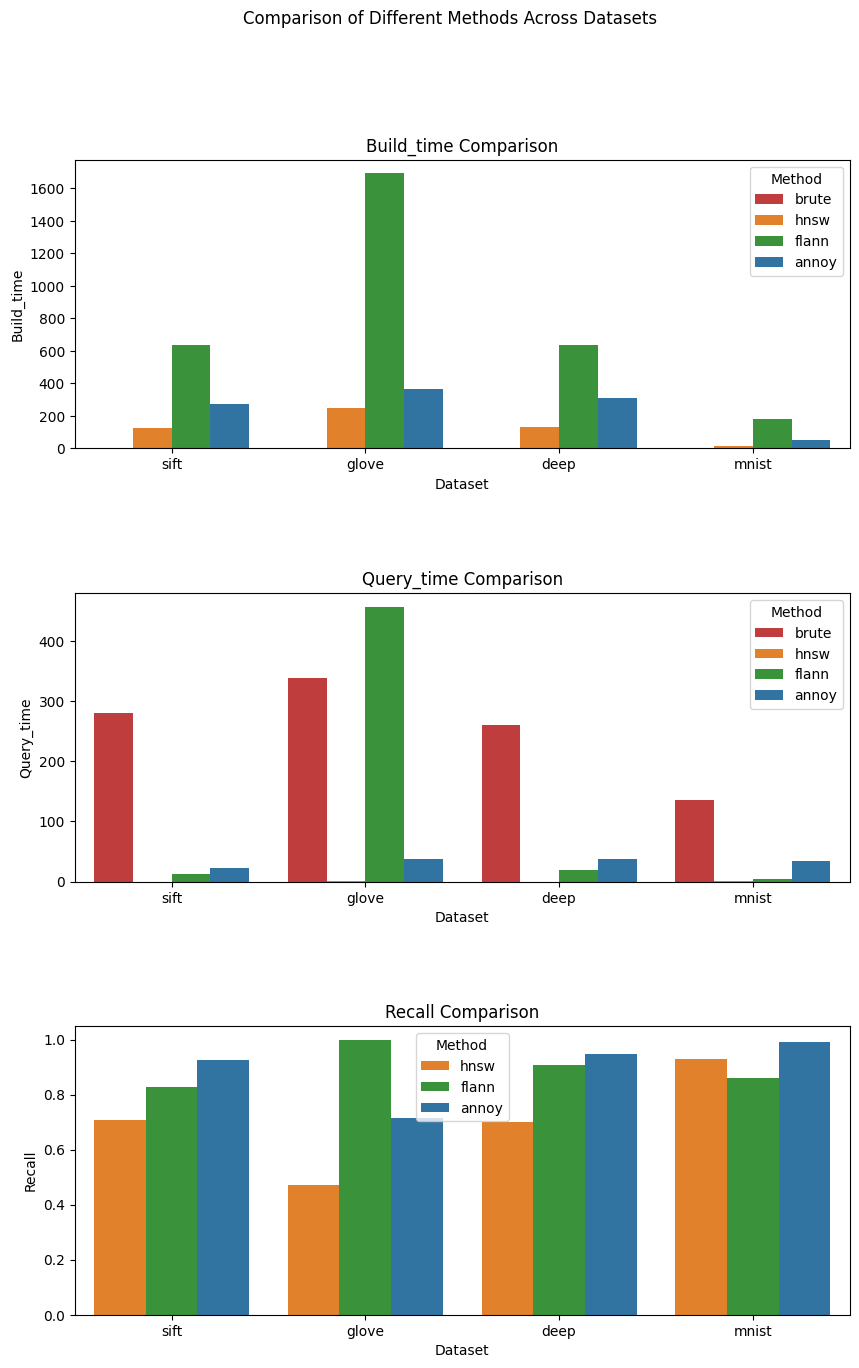

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data Preparation
data = {
    'sift': {
        'brute': {'build_time': 0.5026280879974365, 'query_time': 279.39087867736816},
        'hnsw': {'recall': 0.70828, 'build_time': 123.6417624950409, 'query_time': 0.14356136322021484},
        'flann': {'recall': 0.82904, 'build_time': 638.7001960277557, 'query_time': 13.044065952301025},
        'annoy': {'recall': 0.9267200000000001, 'build_time': 273.279093503952, 'query_time': 22.34026789665222}
    },
    'glove': {
        'brute': {'build_time': 0.6018815040588379, 'query_time': 338.47492504119873},
        'hnsw': {'recall': 0.4706, 'build_time': 246.98338413238525, 'query_time': 0.2142331600189209},
        'flann': {'recall': 0.9999899999999999, 'build_time': 1691.0208961963654, 'query_time': 456.82367396354675},
        'annoy': {'recall': 0.7164299999999999, 'build_time': 367.3854081630707, 'query_time': 37.131975412368774}
    },
    'deep': {
        'brute': {'build_time': 0.5273756980895996, 'query_time': 260.1447868347168},
        'hnsw': {'recall': 0.7000700000000001, 'build_time': 130.78997421264648, 'query_time': 0.1455221176147461},
        'flann': {'recall': 0.9093900000000001, 'build_time': 633.8056845664978, 'query_time': 19.652721643447876},
        'annoy': {'recall': 0.94752, 'build_time': 307.4670329093933, 'query_time': 37.44424319267273}
    },
    'mnist': {
        'brute': {'build_time': 0.05738949775695801, 'query_time': 134.8580060005188},
        'hnsw': {'recall': 0.92871, 'build_time': 17.066320657730103, 'query_time': 0.40122151374816895},
        'flann': {'recall': 0.8596, 'build_time': 179.88845205307007, 'query_time': 4.117311716079712},
        'annoy': {'recall': 0.99325, 'build_time': 49.07278060913086, 'query_time': 33.98891043663025}
    }
}

# Creating DataFrame for each category
categories = ["build_time", "query_time", "recall"]
dfs = {}

for category in categories:
    rows = []
    for dataset, methods in data.items():
        for method, values in methods.items():
            value = values.get(category)
            if value is not None:  # Only include methods that have the category
                rows.append([dataset, method, value])
    dfs[category] = pd.DataFrame(rows, columns=["Dataset", "Method", category])

# Use sns.color_palette() to get a palette of colors
palette = sns.color_palette(n_colors=len(dfs['build_time']['Method'].unique()))

# Map methods to colors
method_colors = {'brute': palette[3], 'hnsw': palette[1], 'flann': palette[2], 'annoy': palette[0]}

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)

for ax, (category, df) in zip(axes, dfs.items()):
    sns.barplot(x="Dataset", y=category, hue="Method", data=df, ax=ax, palette=method_colors)
    ax.set_title(f"{category.capitalize()} Comparison")
    ax.set_ylabel(category.capitalize())
    ax.set_xlabel("Dataset")

plt.suptitle("Comparison of Different Methods Across Datasets")
plt.show()

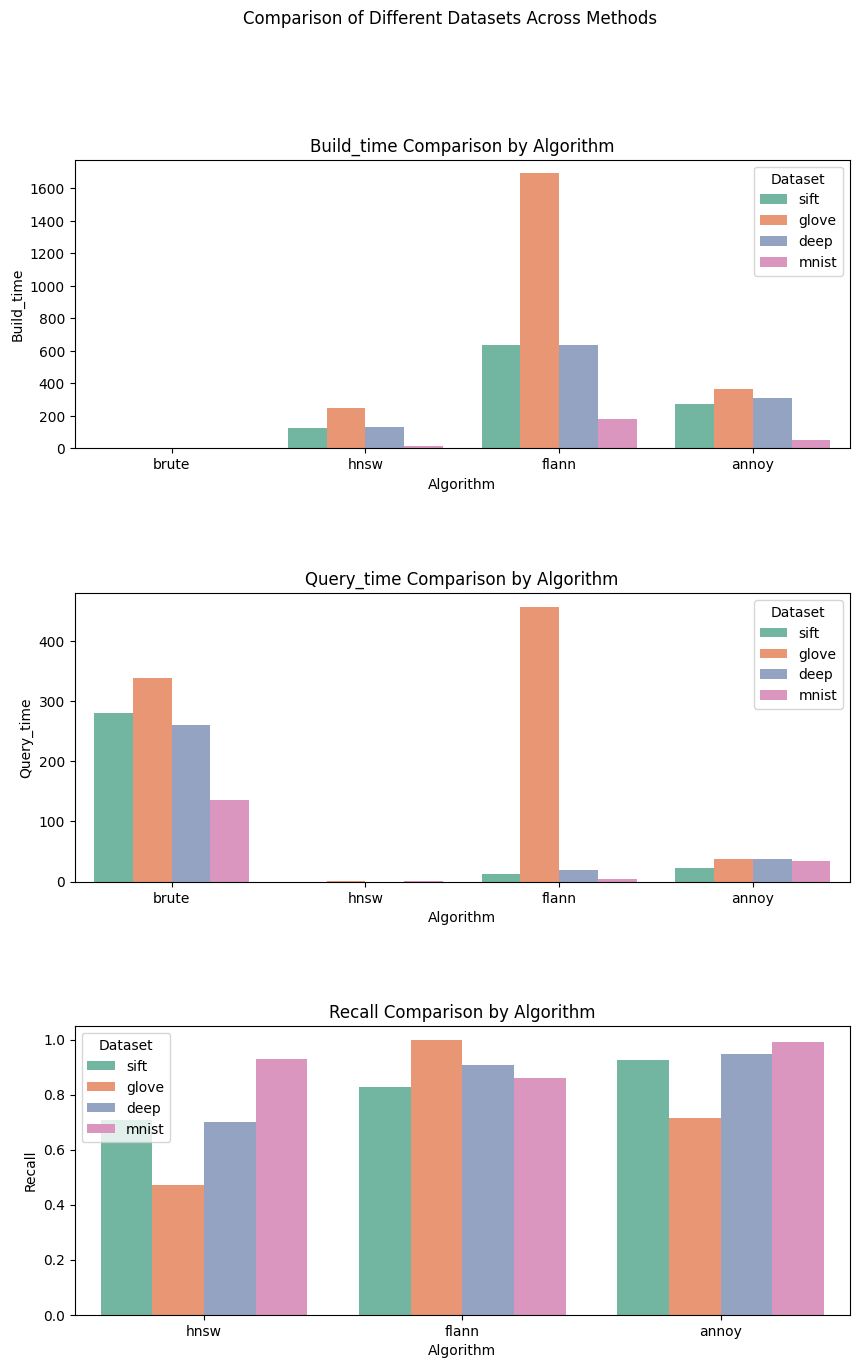

In [14]:
# Adjusting the data for plotting by grouping by method and using dataset as the legend
grouped_dfs = {}

for category in categories:
    rows = []
    for dataset, methods in data.items():
        for method, values in methods.items():
            value = values.get(category)
            if value is not None:  # Only include methods that have the category
                rows.append([method, dataset, value])
    grouped_dfs[category] = pd.DataFrame(rows, columns=["Method", "Dataset", category])
color_palette = "Set2"  # A different color palette
# Plotting the grouped data
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)

for ax, (category, df) in zip(axes, grouped_dfs.items()):
    sns.barplot(x="Method", y=category, hue="Dataset", data=df, palette=color_palette, ax=ax)
    ax.set_title(f"{category.capitalize()} Comparison by Algorithm")
    ax.set_ylabel(category.capitalize())
    ax.set_xlabel("Algorithm")

plt.suptitle("Comparison of Different Datasets Across Methods")
plt.show()